<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Vinod_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [184]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [206]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [207]:
genes_Y_crom = genes[genes.chrom == "Y"].index
genes_bac_index = genes[genes.chrom.isnull()].index
print(len(genes_bac_index))
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  expression - mean_bac_exp.values[:, None]
expression_norm = expression_norm.divide(std_bac_exp, axis=0)

871


A.C. cortex
3
['Y', '11', 'Y', 'X', '16hba1', '7', '3', '11', '12', '6']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'HBB', 'DDX3Y', 'PLP1', NaN, 'ACTB', 'MOBP', 'HBB', 'GAPDH', 'RPS12']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

cerebellum
3
['Y', 'Y', '11', '11', '16hba1', 'X', '18', '17', '4', '19']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'DDX3Y', 'HBB', 'HBB', NaN, 'PLP1', 'MBP', 'GFAP', 'SPP1', 'CIRBP']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

D.L.P.F. cortex
4
['Y', 'Y', '16hba1', '11', '11', '2', '4', 'Y', 'X', '2']
Categories (39, object): ['1', '10', '10ak*', '10ptp*', ..., 'X', 'X Y', 'Y', 'na'] ['RPS4Y1', 'DDX3Y', NaN, 'HBB', 'HBB', 'IGFBP5', 'SPP1', 'KDM5D', 'XIST', 'IGFBP5']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX

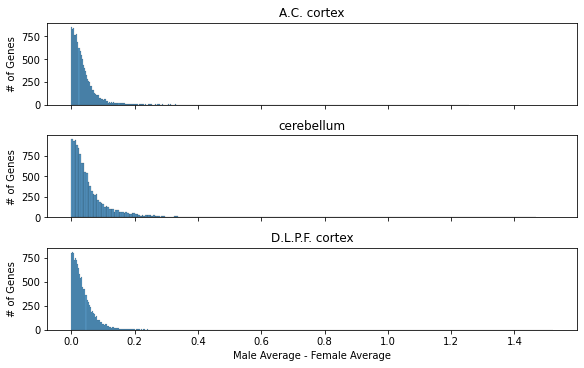

In [208]:
express_norm_samp = pd.concat([expression_norm, samples], axis=1)
fig, axs = plt.subplots(3, 1, figsize=(8, 5), constrained_layout=True, sharex='all')
express_samp_loc = express_norm_samp
c = 0
for tissue in express_samp_loc["region"].unique():
  print(tissue)
  df_male = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "male")]
  df_female = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "female")]

  male_mean = expression_norm.loc[df_male.index].mean()
  female_mean = expression_norm.loc[df_female.index].mean()

  diff = np.abs(male_mean - female_mean)
  sns.histplot(diff, ax = axs[c])
  axs[c].set_title(tissue)
  axs[c].set_xlabel("Male Average - Female Average")
  axs[c].set_ylabel("# of Genes")
  diff = diff.sort_values(ascending=False)
  top_10 = diff.iloc[:10]
  op_chrom = genes.loc[top_10.keys()].loc[:, 'chrom'].values
  op_genes = genes.loc[top_10.keys()].loc[:, 'sym'].values
  chrom_counter = Counter(op_chrom)
  count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
  print(count)
  print(op_chrom, op_genes)
  print("")
  c += 1



